<a href="https://colab.research.google.com/github/nir6760/hw3AI/blob/master/overparameterized_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Foundation of Overparameterized Machine Learning - HW 1 and 2
## Question 5
### Nir Mualem, ID 205467780

In [ ]:
# Import necessary libraries and functions
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.fft import dct
import time

In [ ]:
# for saving check points
# Mount driver to authenticate yourself to gdrive
#from google.colab import drive
#drive.mount('/content/gdrive')
import pandas as pd
from google.colab import files
#---

def save_dataset_to_csv(set_name, arr_x, arr_y):
  if arr_x.ndim == 3:
    # reshaping the array from 3D to 2D for saving
    arr_x = arr_x.reshape(arr_x.shape[0], -1)
  # save to csv file
  np.savetxt(f'X_{set_name}.csv', arr_x, delimiter=',')
  np.savetxt(f'Y_{set_name}.csv', arr_y, delimiter=',')

def upload_dataset_from_csv(set_name, n=None):
  # upload from csv file
  X = pd.read_csv(f'/content/X_{set_name}.csv', sep=',', header=None).to_numpy()
  if n is not None:
    # reshaping the array from 2D to 3D
    X = X.reshape(X.shape[0], n, X.shape[1] // n)
  Y = pd.read_csv(f'/content/Y_{set_name}.csv', sep=',', header=None).to_numpy()
  return X, Y

def print_time(display_str, start, end):
  running_time_sec = round(end - start,3)
  running_time_min = round(running_time_sec/60,3)
  print(f'{display_str} - runing time: {running_time_sec} sec ~ {running_time_min} min')

# function for saving figures
def save_and_download_fig(title):
  plt.savefig(f"{title}.png", dpi=500)
  files.download(f"{title}.png")

In [ ]:
d = 128

C = dct(np.eye(d), axis=0, norm='ortho')

lambda_x = np.zeros((d, d), float) # Create matrix with only 0
lambda_x_diag = np.array([3*np.power(0.9,j-1) for j in range(1, d+1)]).reshape(d,1)
np. fill_diagonal(lambda_x, lambda_x_diag) # fill diagonal with 1.


mean_x = np.zeros((d,1)).reshape(d)

cov_x = np.matmul(np.matmul(C,lambda_x) ,np.transpose(C))

mu_xi = 0
sigma_squared_noise = 0.25

beta_tilde = np.array([0.2178] * 20 + [0.0218] * 108).reshape(d, 1)
beta = np.matmul(C, beta_tilde)


#### **(a)** Train dataset creation

In [ ]:
X = np.random.multivariate_normal(mean_x, cov_x, size=(2,32), check_valid='warn')# nxd
np.linalg.matrix_rank(X[0])

32

In [ ]:
n = 32

In [ ]:
def crate_dataset(set_name, n, X, Y, d, K=1):
  start_create_dataset = time.time()
  rank_required = min(n, d)
  rank_of_X = 0
  while(rank_of_X < rank_required):
    rank_of_X = 0 if K==1 else rank_required # only for section b we will repeat for getting  iid xi's
    Epsilon = np.random.normal(mu_xi, sigma_squared_noise, size=(K,n)) # nx1
    X = np.random.multivariate_normal(mean_x, cov_x, size=(K,n), check_valid='warn')# nxd
    if K==1:
      rank_of_X = np.linalg.matrix_rank(X[0])
      if (rank_of_X < rank_required):
        continue
    for k in range(K):
      for i in range(n):
          #xi = xi.reshape(d,1)
          yki = np.matmul(np.transpose(X[k,i,:]), beta) + Epsilon[k,i]
          yki = float(yki.ravel())
          if K==1:
            Y[i] = yki
          else:
            Y[k,i] = yki
  end_time_create_dataset = time.time()
  print_time('Dataset creation', start_create_dataset, end_time_create_dataset)
  if K==1:
     print(f'X ({set_name}) rank = {rank_of_X}')
     X = X.squeeze()
     Y = Y.squeeze()
  return X, Y

**Rank of the matrix X (train) should be n (train) < d**

In [ ]:
X_train = np.zeros((n,d))
Y_train = np.zeros((n,))

X_train, Y_train = crate_dataset('train', n, X_train, Y_train, d)
#save_dataset_to_csv('train', X_train, Y_train) # save to csv file
#X_train, Y_train = upload_dataset_from_csv('train') # upload from csv file

Dataset creation - runing time: 0.034 sec ~ 0.001 min
X (train) rank = 32


#### **(b)** Test dataset creation




In [ ]:
n_test = 1000

**Rank of the matrix X (test)**

In [ ]:
X_test = np.zeros((n_test,d))
Y_test = np.zeros((n_test,))

X_test, Y_test = crate_dataset('test', n_test, X_test, Y_test, d)

#save_dataset_to_csv('test', X_test, Y_test) # save to csv file
#X_test, Y_test = upload_dataset_from_csv('test') # upload from csv file

Dataset creation - runing time: 0.04 sec ~ 0.001 min
X (test) rank = 128


#### **(c)** empirical test error, single data set

In [ ]:
class FHatP:
  # Min L2-Norm
  def __init__(self, p, X, Y) -> None:
    self.p_index = p-1
    self.X = X
    self.Y = Y


    self.U_p = C[:,0:p]

    self.Phi = np.matmul(self.X, self.U_p)
    Phi_t_Phi = np.matmul(np.transpose(self.Phi), self.Phi)
    rank_of_Phi_t_Phi = np.linalg.matrix_rank(Phi_t_Phi)
    if rank_of_Phi_t_Phi < p:
      # no inverse
      self.alpha_min = np.matmul(np.linalg.pinv(self.Phi), Y)
    else:
      self.alpha_min = np.matmul( np.matmul(np.linalg.inv(Phi_t_Phi) ,np.transpose(self.Phi)), Y)

  def calc_y_hat(self, x):

    y_hat = np.matmul(np.matmul(np.transpose(self.alpha_min), np.transpose(self.U_p)), x)
    return y_hat

  def __call__(self, x):
    return self.calc_y_hat(x)

  # calculate the empirical test error
  def calc_test_error(self, X_test, Y_test, n_test):
    return sum(np.power(self.calc_y_hat(X_test[i]) - Y_test[i],2) for i in range(n_test)) / n_test

class FNullEstimator:
  # Null Estimator class
  def __init__(self, p, Y) -> None:
    self.p_index = p-1
    self.Y = Y

  def calc_y_hat(self, x):
    y_hat = 0
    return y_hat

  def __call__(self, x):
    return self.calc_y_hat(x)

  # calculate the empirical test error
  def calc_test_error(self, Y_test, n_test):
    return sum(np.power(0 - Y_test[i],2) for i in range(n_test)) / n_test


In [ ]:
from scipy.optimize import linprog
class FHatPNorm1:
  # Min L1-Norm
  def __init__(self, p, X, Y) -> None:
    self.p_index = p-1
    self.X = X
    self.Y = Y
    self.l1_norm_flag = False

    self.U_p = C[:,0:p]

    self.Phi = np.matmul(self.X, self.U_p)


    Phi_t_Phi = np.matmul(np.transpose(self.Phi), self.Phi)
    rank_of_Phi_t_Phi = np.linalg.matrix_rank(Phi_t_Phi)
    if rank_of_Phi_t_Phi < p:
      # no inverse, linear programing
      # numRows = size(mA, 1);
      # numCols = size(mA, 2);
      # % vU = max(vX, 0);
      # % vV = max(-vX, 0);
      # % vX = vU - vX;
      # % vUV = [vU; vV];
      # vF = ones([2 * numCols, 1]);
      # mAeq = [mA, -mA];
      # vBeq = vB;
      # vLowerBound = zeros([2 * numCols, 1]);
      # vUpperBound = inf([2 * numCols, 1]);
      # sSolverOptions = optimoptions('linprog', 'Display', 'off');
      # vUV = linprog(vF, [], [], mAeq, vBeq, vLowerBound, vUpperBound, sSolverOptions);
      # vX = vUV(1:numCols) - vUV(numCols + 1:end);
      num_rows = self.Phi.shape[0]
      num_cols = self.Phi.shape[1]
      v_f = np.ones(2 * num_cols,)
      mAeq = np.concatenate((self.Phi, -1 * self.Phi), axis=1)
      vBeq = self.Y
      bound = (0, np.inf)
      bounds_lst = [bound]*2*num_cols
      vUV = linprog(c=v_f, A_eq=mAeq, b_eq=vBeq,bounds=bounds_lst,method="revised simplex")
      if vUV.status != 0 or not vUV.success:
        print(f'Error occured in linprog, status is {vUV.status}, success is {vUV.success}')
      vX = vUV.x[0:num_cols] - vUV.x[num_cols :]
      vX =vX .squeeze()
      self.alpha_min = vX
    else:
      # closed solution
      self.alpha_min = np.matmul( np.matmul(np.linalg.inv(Phi_t_Phi) ,np.transpose(self.Phi)), Y)

  def calc_y_hat(self, x):
    y_hat = np.matmul(np.matmul(np.transpose(self.alpha_min), np.transpose(self.U_p)), x)
    return y_hat

  def __call__(self, x):
    return self.calc_y_hat(x)

  # calculate the empirical test error
  def calc_test_error(self, X_test, Y_test, n_test):
      return sum(np.power(self.calc_y_hat(X_test[i]) - Y_test[i],2) for i in range(n_test)) / n_test

In [ ]:
p_vals = range(1, d+1)
f_hat_error_valsNorm1 = [FHatPNorm1(p, X_train, Y_train).calc_test_error(X_test, Y_test, n_test) for p in p_vals]

In [ ]:
p_vals = range(1, d+1)
f_hat_error_vals = [FHatP(p, X_train, Y_train).calc_test_error(X_test, Y_test, n_test) for p in p_vals]
f_hat_error_valsNullEstimator = [FNullEstimator(p, Y_train).calc_test_error(Y_test, n_test) for p in p_vals]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

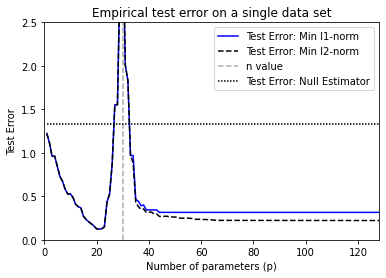

In [ ]:
# plot sea born
ax1 = sns.lineplot(x=p_vals, y=f_hat_error_valsNorm1, color="blue")
ax2 = sns.lineplot(x=p_vals, y=f_hat_error_vals, linestyle="dashed", color="black")
# giving labels to x-axis and y-axis
ax1.set(xlabel ='Number of parameters (p)', ylabel ='Test Error')
ax1.set(ylim=(0, 2.5))
ax1.set(xlim=(0, d))
ax1.axvline(n-2 , color='darkgray', linestyle="dashed")

ax3 = sns.lineplot(x=p_vals, y=f_hat_error_valsNullEstimator,linestyle=(0, (1, 1)), color="black")
plt.legend(labels=[ 'Test Error: Min l1-norm', 'Test Error: Min l2-norm' , 'n value', 'Test Error: Null Estimator'])
# giving title to the plot
plt.title('Empirical test error on a single data set');

# function to show plot
#save_and_download_fig("hw2q5_1")
plt.show()

#### **(d)** empirical test error, averaging on multiple data set

In [ ]:
K = 700

In [ ]:
X_trains = np.zeros((K, n,d))
Y_trains = np.zeros((K,n))

X_trains, Y_trains = crate_dataset('trains', n, X_trains, Y_trains, d, K)
#save_dataset_to_csv('trains', X_trains, Y_trains) # save to csv file
#X_train, Y_train = upload_dataset_from_csv('trains') # upload from csv file

Dataset creation - runing time: 0.465 sec ~ 0.008 min


In [ ]:
# create all the functions f for every k,p
def create_lattice_f(minL2_flag=True):
  if minL2_flag:
    fp = FHatP
  else:
    fp= FHatPNorm1
  start_time_lattice = time.time()
  lattice_f = np.empty( (K,d), dtype=object)
  for k_iter in range(K):
    lattice_f[k_iter, :] = [fp(p, X_trains[k_iter], Y_trains[k_iter]) for p in p_vals]
    if k_iter % 10 == 0:
      end_time_k_10 = time.time()
      print_time(f'Status update : k = {k_iter}', start_time_lattice, end_time_k_10)
  end_time_lattice = time.time()
  print_time(f'Lattice minl{2 if minL2_flag else 1}', start_time_lattice, end_time_lattice)
  return lattice_f

# calculate the value for average function p (p 0-index)
def f_average_p(lattice_f, p, x):
  return sum(lattice_f[k_iter,p](x) for k_iter in range(K)) / K

# calculate the empirical average train error per p (p 1-index)
def calc_average_train_error(lattice_f, p):
  return sum(lattice_f[k_iter,p-1].calc_test_error(X_trains[k_iter],  Y_trains[k_iter], n) for k_iter in range(K)) / K

# calculate the empirical average null estimator error per p (p 1-index)
def calc_average_null_estimator_error(p):
  return sum(np.power(0 - Y_test[i_iter],2) for i_iter in range(n_test)) / n_test

# calculate the empirical average test error per p (p 1-index)
def calc_average_test_error(lattice_f, p, n_test):
  return sum(lattice_f[k_iter,p-1].calc_test_error(X_test, Y_test, n_test) for k_iter in range(K)) / K

# calculate the empirical squared bias per p (p 1-index)
def calc_squared_bias(lattice_f, p, n_test):
  return float(sum(np.power(f_average_p(lattice_f, p-1, X_test[i]) - np.matmul(np.transpose(beta),X_test[i]),2) for i in range(n_test)) / n_test)

# calculate the empirical variance per p (p 1-index)
def calc_variance(lattice_f, p, n_test):
  return sum(sum(np.power(lattice_f[k_iter, p-1](X_test[i]) - f_average_p(lattice_f, p-1, X_test[i]),2) for i in range(n_test)) for k_iter in range(K)) / (K*n_test)

# calculate all requirments in section d per p (p 1-index)
def calc_error_bias_variance(lattice_f, p, n_test):
  averaged_test_err = 0
  averaged_null_test_err = 0
  bias_square = 0
  variance = 0
  cache_f_avep_x = [None] * n_test
  for k_iter in range(K):
    for i in range(n_test):
      f_pk_x = lattice_f[k_iter, p-1](X_test[i])
      if cache_f_avep_x[i] is None:
        f_avep_x = f_average_p(lattice_f, p-1, X_test[i])
        cache_f_avep_x[i] = f_avep_x
      else:
        f_avep_x = cache_f_avep_x[i]

      averaged_test_err = averaged_test_err + np.power((f_pk_x - Y_test[i]),2)
      averaged_null_test_err = averaged_null_test_err + np.power((0 - Y_test[i]),2)
      if k_iter == 0:
        # only one iteration
        betat_x = np.matmul(np.transpose(beta),X_test[i])
        bias_square = bias_square + float(np.power((f_avep_x - betat_x),2))
      variance = variance + np.power((f_pk_x - f_avep_x),2)

  averaged_test_err = averaged_test_err / (K*n_test)
  averaged_null_test_err = averaged_null_test_err / (K*n_test)
  bias_square = bias_square / (n_test)
  variance = variance / (K*n_test)
  return averaged_test_err, bias_square , variance, averaged_null_test_err


In [ ]:
lattice_f = create_lattice_f() # 4 min for k=700

Lattice minl2 - runing time: 224.459 sec ~ 3.741 min


In [ ]:
lattice_f_minl1 = create_lattice_f(minL2_flag=False)# 28 min for k=700

Lattice minl1 - runing time: 1710.293 sec ~ 28.505 min


## HW2 - Question 5

In [ ]:
start_time_calculations = time.time()
average_test_error_vals = []
average_test_error_minl1_vals = []
average_train_error_vals = []
average_train_error_minl1_vals = []
averaged_null_test_err_vals = []
for p in p_vals:
  averaged_test_err = calc_average_test_error(lattice_f, p, n_test)
  average_test_error_vals.append(averaged_test_err)

  averaged_test_minl1_err = calc_average_test_error(lattice_f_minl1, p, n_test)
  average_test_error_minl1_vals.append(averaged_test_minl1_err)

  average_train_error = calc_average_train_error(lattice_f, p)
  average_train_error_vals.append(average_train_error)

  average_train_error_minl1 = calc_average_train_error(lattice_f_minl1, p)
  average_train_error_minl1_vals.append(average_train_error_minl1)

  averaged_null_test_err = calc_average_null_estimator_error(p)
  averaged_null_test_err_vals.append(averaged_null_test_err)
  if p % 10 == 0:
    end_time_p_10 = time.time()
    print_time(f'Status update : p = {p}', start_time_calculations, end_time_p_10)
end_time_calculations = time.time()
print_time('Test errors calculations', start_time_calculations, end_time_calculations)

Status update : p = 10 - runing time: 194.403 sec ~ 3.24 min
Status update : p = 20 - runing time: 381.879 sec ~ 6.365 min
Status update : p = 30 - runing time: 569.848 sec ~ 9.497 min
Status update : p = 40 - runing time: 764.402 sec ~ 12.74 min
Status update : p = 50 - runing time: 962.561 sec ~ 16.043 min
Status update : p = 60 - runing time: 1160.635 sec ~ 19.344 min
Status update : p = 70 - runing time: 1363.132 sec ~ 22.719 min
Status update : p = 80 - runing time: 1718.715 sec ~ 28.645 min
Status update : p = 90 - runing time: 2092.067 sec ~ 34.868 min
Status update : p = 100 - runing time: 2468.426 sec ~ 41.14 min
Status update : p = 110 - runing time: 2850.437 sec ~ 47.507 min
Status update : p = 120 - runing time: 3240.323 sec ~ 54.005 min
Test errors calculations - runing time: 3550.709 sec ~ 59.178 min


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

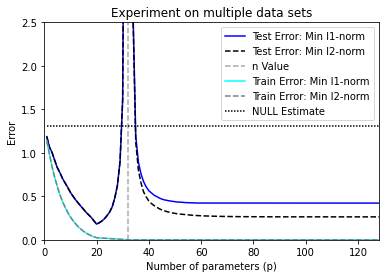

In [ ]:
# plot sea born
my_dict = dict(x=p_vals, y1=average_test_error_vals, y2=average_test_error_minl1_vals, y3=average_train_error_vals, y4=average_train_error_minl1_vals, y5=averaged_null_test_err_vals)
data = pd.DataFrame (my_dict)


ax2= sns.lineplot(x='x', y='y2', data=data, color='blue')
ax3 = sns.lineplot(x='x', y='y1', data=data,linestyle="dashed", color="black")
ax2.axvline(n , color='darkgray', linestyle="dashed")
ax4 = sns.lineplot(x='x', y='y4', data=data, color='aqua')
ax5 = sns.lineplot(x='x', y='y3', data=data, linestyle="dashed", color='gray')
ax6 = sns.lineplot(x='x', y='y5', data=data,linestyle=(0, (1, 1)), color="black")
plt.legend(labels=['Test Error: Min l1-norm' ,'Test Error: Min l2-norm', 'n Value','Train Error: Min l1-norm', 'Train Error: Min l2-norm' ,'NULL Estimate'])

# giving labels to x-axis and y-axis
ax2.set(xlabel ='Number of parameters (p)', ylabel ='Error')
ax2.set(ylim=(0, 2.5))
ax2.set(xlim=(0, d))
# giving title to the plot
plt.title('Experiment on multiple data sets')



# function to show plot
#save_and_download_fig("hw2q5_2")
plt.show()

## HW1 1 - Question 5

In [ ]:
# start_time_calculations = time.time()
# average_test_error_vals = []
# squared_bias_vals = []
# variance_vals = []
# averaged_null_test_err_vals = []
# for p in p_vals:
#   averaged_test_err, squared_bias, variance, averaged_null_test_err = calc_error_bias_variance(lattice_f, p, n_test)
#   average_test_error_vals.append(averaged_test_err)
#   squared_bias_vals.append(squared_bias)
#   variance_vals.append(variance)
#   averaged_null_test_err_vals.append(averaged_null_test_err)
#   if p % 10 == 0:
#     end_time_p_10 = time.time()
#     print_time(f'Status update : p = {p}', start_time_calculations, end_time_p_10)
# end_time_calculations = time.time()
# print_time('Section d calculations', start_time_calculations, end_time_calculations)

Status update : p = 10 - runing time: 206.399 sec ~ 3.44 min
Status update : p = 20 - runing time: 419.098 sec ~ 6.985 min
Status update : p = 30 - runing time: 639.492 sec ~ 10.658 min
Status update : p = 40 - runing time: 864.735 sec ~ 14.412 min
Status update : p = 50 - runing time: 1085.276 sec ~ 18.088 min
Status update : p = 60 - runing time: 1313.526 sec ~ 21.892 min
Status update : p = 70 - runing time: 1545.525 sec ~ 25.759 min
Status update : p = 80 - runing time: 1957.205 sec ~ 32.62 min
Status update : p = 90 - runing time: 2391.42 sec ~ 39.857 min
Status update : p = 100 - runing time: 2823.875 sec ~ 47.065 min
Status update : p = 110 - runing time: 3293.368 sec ~ 54.889 min
Status update : p = 120 - runing time: 3740.954 sec ~ 62.349 min
Section d calculations - runing time: 4098.008 sec ~ 68.3 min


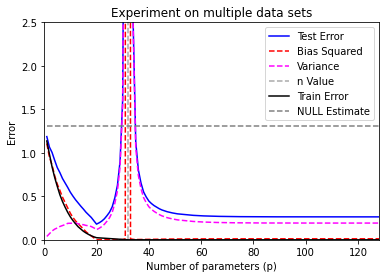

In [ ]:
# # plot sea born
# my_dict = dict(x=p_vals, y1=average_test_error_vals, y2=squared_bias_vals, y3=variance_vals, y4=average_train_error_vals, y5=averaged_null_test_err_vals)
# data = pd.DataFrame (my_dict)

# ax2= sns.lineplot(x='x', y='y1', data=data, color='blue')
# ax3 = sns.lineplot(x='x', y='y2', data=data, color='red', linestyle="dashed")
# ax4 = sns.lineplot(x='x', y='y3', data=data, color='fuchsia', linestyle="dashed")
# ax2.axvline(n , color='darkgray', linestyle="dashed")
# ax5 = sns.lineplot(x='x', y='y4', data=data, color='black')
# ax6 = sns.lineplot(x='x', y='y5', data=data, linestyle="dashed", color='gray')
# plt.legend(labels=['Test Error', 'Bias Squared', 'Variance', 'n Value', 'Train Error', 'NULL Estimate'])

# # giving labels to x-axis and y-axis
# ax2.set(xlabel ='Number of parameters (p)', ylabel ='Error')
# ax2.set(ylim=(0, 2.5))
# ax2.set(xlim=(0, d))
# # giving title to the plot
# plt.title('Experiment on multiple data sets')



# # function to show plot
# #save_and_download_fig("section_d_limited_two_smoother2")
# plt.show()